# Library

In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from matplotlib import pyplot as plt
from keras.layers import Dense, LSTM
from pandas import read_csv

import tensorflow as tf
import numpy as np

In [60]:
np.set_printoptions(linewidth=np.inf)

# Forecasting Univariate Timeseries (satu variabel)

### Load data

In [3]:
df = read_csv('https://drive.google.com/uc?id=15RfMD9lNkpS3cVN7j3_dsJKZ8_5RJG5z')
df.head(1)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.0,84.5,0.0,1015.666667


In [4]:
# df.isnull()
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [7]:
dates = df['date'].values
temp = df['meantemp'].values

### Plotting data

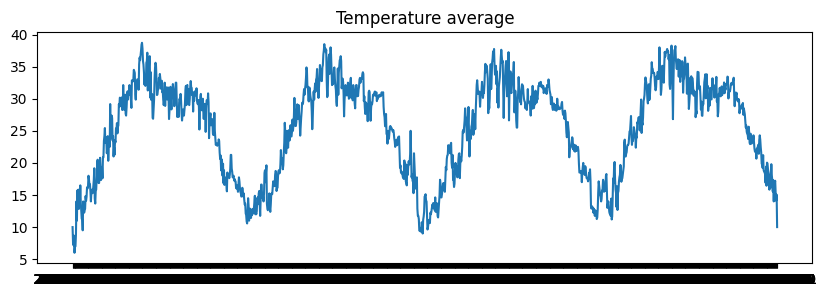

In [8]:
plt.figure(figsize=(10,3))
plt.plot(dates, temp)
plt.title('Temperature average', fontsize=12);

## Preprocessing

### window function

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

### Splitting Data

In [10]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)

In [11]:
for x in train_set: 
    print(x)
    break

(<tf.Tensor: shape=(100, 60, 1), dtype=float64, numpy=
array([[[37.8       ],
        [35.85714286],
        [35.33333333],
        ...,
        [29.5       ],
        [31.85714286],
        [29.71428571]],

       [[24.        ],
        [23.875     ],
        [24.125     ],
        ...,
        [15.125     ],
        [14.125     ],
        [14.        ]],

       [[18.25      ],
        [17.875     ],
        [17.625     ],
        ...,
        [12.28571429],
        [12.        ],
        [12.5       ]],

       ...,

       [[30.        ],
        [29.5       ],
        [30.75      ],
        ...,
        [29.71428571],
        [29.2       ],
        [30.83333333]],

       [[26.875     ],
        [28.4       ],
        [29.85714286],
        ...,
        [30.75      ],
        [29.66666667],
        [27.71428571]],

       [[13.25      ],
        [13.75      ],
        [13.25      ],
        ...,
        [24.75      ],
        [25.75      ],
        [26.625     ]]])>, <tf.Tensor: 

## Modelling

In [16]:
lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
lstm.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

In [17]:
lstm_history = lstm.fit(train_set, epochs=100)

Epoch 1/100
15/15 [==============================] - 6s 40ms/step - loss: 25.7589 - mae: 26.2589
Epoch 2/100
15/15 [==============================] - 1s 23ms/step - loss: 25.5599 - mae: 26.0599
Epoch 3/100
15/15 [==============================] - 1s 25ms/step - loss: 25.4876 - mae: 25.9876
Epoch 4/100
15/15 [==============================] - 1s 22ms/step - loss: 25.4518 - mae: 25.9518
Epoch 5/100
15/15 [==============================] - 1s 28ms/step - loss: 25.4169 - mae: 25.9169
Epoch 6/100
15/15 [==============================] - 1s 25ms/step - loss: 25.3499 - mae: 25.8499
Epoch 7/100
15/15 [==============================] - 1s 24ms/step - loss: 25.2479 - mae: 25.7479
Epoch 8/100
15/15 [==============================] - 1s 21ms/step - loss: 25.1405 - mae: 25.6405
Epoch 9/100
15/15 [==============================] - 1s 26ms/step - loss: 25.0381 - mae: 25.5381
Epoch 10/100
15/15 [==============================] - 1s 33ms/step - loss: 24.9440 - mae: 25.4440
Epoch 11/100
15/15 [=========

In [35]:
forecast = lstm_history.model.predict(train_set)
print(forecast[:10])

15/15 [==============================] - 1s 22ms/step
[[27.344181]
 [25.178503]
 [31.398592]
 [32.130306]
 [33.971134]
 [17.265766]
 [30.072405]
 [30.34339 ]
 [31.49311 ]
 [22.467487]]


# Multivariate Time Series

## Load data

In [54]:
df = read_csv('./household_power_consumption.csv', sep=',', infer_datetime_format=True, index_col='datetime', header=0)
df.head()

/tmp/ipykernel_29737/209416609.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = read_csv('./household_power_consumption.csv', sep=',', infer_datetime_format=True, index_col='datetime', header=0)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Normalisasi Data

In [74]:
def normalize_series(data, min, max):
    return (data - min) / max
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

In [76]:
data.shape

(86400, 7)

In [65]:
N_FEATURES = len(df.columns)
N_FEATURES

7

## Splitting Data

In [70]:
SPLIT_TIME = int(len(data) * 0.5)
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

## preprocessing

In [68]:
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [71]:
BATCH_SIZE = 32
N_PAST = 24
N_FUTURE = 24
SHIFT = 1
# Kode untuk membuat windowed datasets
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)

In [72]:
for data in train_set:
    print(data)
    break

(<tf.Tensor: shape=(32, 24, 7), dtype=float64, numpy=
array([[[0.43377912, 0.47826087, 0.04036551, ..., 0.        , 0.01282051, 0.85      ],
        [0.55716135, 0.49885584, 0.0355582 , ..., 0.        , 0.01282051, 0.8       ],
        [0.55867127, 0.56979405, 0.03420739, ..., 0.        , 0.02564103, 0.85      ],
        ...,
        [0.81018119, 0.        , 0.0250298 , ..., 0.        , 0.        , 0.85      ],
        [0.73684211, 0.        , 0.02991657, ..., 0.        , 0.        , 0.8       ],
        [0.53710095, 0.        , 0.03778308, ..., 0.        , 0.        , 0.85      ]],

       [[0.55716135, 0.49885584, 0.0355582 , ..., 0.        , 0.01282051, 0.8       ],
        [0.55867127, 0.56979405, 0.03420739, ..., 0.        , 0.02564103, 0.85      ],
        [0.56018119, 0.57437071, 0.03599523, ..., 0.        , 0.01282051, 0.85      ],
        ...,
        [0.73684211, 0.        , 0.02991657, ..., 0.        , 0.        , 0.8       ],
        [0.53710095, 0.        , 0.03778308, ...

## Modeling

In [79]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('mae') < 0.055 and logs.get('val_mae') < 0.055):
                self.model.stop_training = True
 
callbacks = myCallback()

In [78]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_shape=(N_PAST, N_FEATURES)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(N_FEATURES)
    ])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 24, 64)            512       
                                                                 
 dense_19 (Dense)            (None, 24, 32)            2080      
                                                                 
 dense_20 (Dense)            (None, 24, 7)             231       
                                                                 
Total params: 2823 (11.03 KB)
Trainable params: 2823 (11.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 
model.compile(loss='mae',
                  optimizer= optimizer,
                  metrics=["mae"])

In [81]:
model.fit(train_set,
          validation_data=(valid_set),
          epochs=100,
          callbacks=callbacks,
          verbose=1
    )

Epoch 1/100
1349/1349 [==============================] - 29s 20ms/step - loss: 0.0713 - mae: 0.0713 - val_loss: 0.0622 - val_mae: 0.0622
Epoch 2/100
1349/1349 [==============================] - 25s 19ms/step - loss: 0.0600 - mae: 0.0600 - val_loss: 0.0574 - val_mae: 0.0574
Epoch 3/100
1349/1349 [==============================] - 26s 19ms/step - loss: 0.0590 - mae: 0.0590 - val_loss: 0.0587 - val_mae: 0.0587
Epoch 4/100
1349/1349 [==============================] - 28s 21ms/step - loss: 0.0582 - mae: 0.0582 - val_loss: 0.0575 - val_mae: 0.0575
Epoch 5/100
1349/1349 [==============================] - 33s 24ms/step - loss: 0.0576 - mae: 0.0576 - val_loss: 0.0570 - val_mae: 0.0570
Epoch 6/100
1349/1349 [==============================] - 31s 23ms/step - loss: 0.0577 - mae: 0.0577 - val_loss: 0.0570 - val_mae: 0.0570
Epoch 7/100
1349/1349 [==============================] - 32s 23ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0568 - val_mae: 0.0568
Epoch 8/100
1349/1349 [==================

In [84]:
train_pred = model.predict(train_set)
train_pred[0]

1349/1349 [==============================] - 12s 9ms/step


array([[ 3.7588540e-01,  2.3848110e-01,  2.6133846e-02,  3.5615361e-01,  9.9153037e-04,  8.1854890e-04,  8.6487585e-01],
       [ 3.9641398e-01,  2.7933955e-01,  2.1787211e-02,  3.8582742e-01,  1.2839139e-03,  8.9537108e-04,  8.0352372e-01],
       [ 3.9228150e-01,  2.9699859e-01,  1.7460864e-02,  3.8474858e-01,  1.2656838e-03,  9.7406213e-04,  8.5630858e-01],
       [ 3.8889429e-01,  2.9993790e-01,  1.7773543e-02,  3.8218564e-01,  1.2221984e-03,  1.0267553e-03,  8.5421646e-01],
       [ 3.0994460e-01,  2.6092285e-01,  2.8083973e-02,  2.9549059e-01,  7.7359297e-04,  6.5377820e-04,  8.6518055e-01],
       [ 3.0184183e-01,  2.5502226e-01,  2.9232392e-02,  2.8645223e-01,  8.4758049e-04,  4.7598162e-04,  8.6902100e-01],
       [ 3.1387424e-01,  2.5991896e-01,  2.7506217e-02,  2.9941320e-01,  8.4666943e-04,  6.1269256e-04,  8.6656886e-01],
       [ 3.1375173e-01,  2.5962597e-01,  2.7676165e-02,  2.9915127e-01,  8.3075324e-04,  6.2254578e-04,  8.6629111e-01],
       [ 3.1606096e-01,  2.58392

In [92]:
train_pred[0][0]

array([3.7588540e-01, 2.3848110e-01, 2.6133846e-02, 3.5615361e-01, 9.9153037e-04, 8.1854890e-04, 8.6487585e-01], dtype=float32)